In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import RBFInterpolator

import warnings
warnings.filterwarnings('ignore')

## 构造数据

<Axes: >

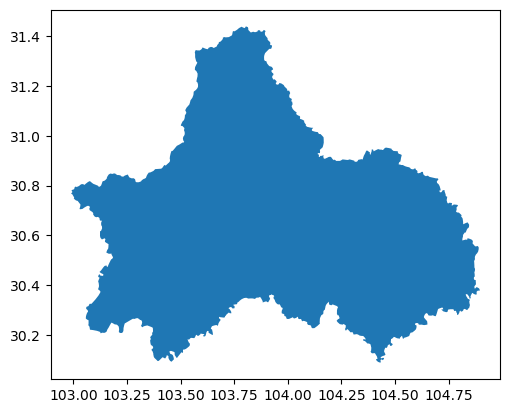

In [2]:
gdf = gpd.read_file('../data/chengdu.geojson')
gdf.plot()

In [3]:
def make_grid(boundary: gpd.GeoDataFrame, radius: float) -> gpd.GeoDataFrame:
    # 以边界的中心点按照radius半径进行外扩
    minx, miny, maxx, maxy = boundary.total_bounds
    deltax = ((maxx-minx)%(radius*2)) / 2
    deltay = ((maxy-miny)%(radius*2)) / 2
    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay
    cells = []
    for x in np.arange(minx, maxx, radius*2):
        for y in np.arange(miny, maxy, radius*2):
            cells.append(Polygon([(x,y),(x,y+radius*2),(x+radius*2,y+radius*2),(x+radius*2,y),(x,y)]))
    return gpd.GeoDataFrame(cells,columns=['geometry'],crs=boundary.crs).sjoin(boundary,how='inner') 

def generate_data(gdf: gpd.GeoDataFrame, select_num: int=100, col: str='Feature') -> gpd.GeoDataFrame:
    selected_indices = np.random.choice(gdf.index, select_num, replace=False)
    selected_gdf = gdf.loc[selected_indices].copy()
    selected_gdf['value'] = np.random.uniform(0, 100, select_num) # 生成浮点数

    # 提取选定格网的中心坐标和值
    # 注意：几何中心可能不是最佳选择，但对于均匀格网通常可行。
    # 对于非均匀格网，可能需要更精细的质心计算或使用格网的质心。
    selected_coords = np.array([[p.x, p.y] for p in selected_gdf.geometry.centroid])
    selected_values = selected_gdf['value'].values
    all_grid_coords = np.array([[p.x, p.y] for p in gdf.geometry.centroid])  # 提取所有格网的中心坐标，作为插值目标点

    # 径向基函数 (RBF) 插值
    # 通常比最近邻平滑，有多种核函数可选
    # 常用核函数: 'gaussian', 'linear', 'cubic', 'multiquadric', 'inverse_multiquadric'
    interpolator_rbf = RBFInterpolator(selected_coords, selected_values, kernel='linear')
    gdf[col] = interpolator_rbf(all_grid_coords)
    gdf[gdf[col]<0][col] = 0
    
    return gdf[[col]]

In [4]:
grid = make_grid(gdf, 0.01/2)  
grid = grid.drop(columns='index_right').reset_index(drop=True)

# 添加 FID 用于数值连接
grid['FID'] = grid.index
grid

,geometry,地级码,地级,省级,省级码,FID
0,"POLYGON ((102.9863 30.75759, 102.9863 30.76759...",510100,成都市,四川省,510000,0
1,"POLYGON ((102.9863 30.76759, 102.9863 30.77759...",510100,成都市,四川省,510000,1
2,"POLYGON ((102.9863 30.77759, 102.9863 30.78759...",510100,成都市,四川省,510000,2
3,"POLYGON ((102.9963 30.73759, 102.9963 30.74759...",510100,成都市,四川省,510000,3
4,"POLYGON ((102.9963 30.74759, 102.9963 30.75759...",510100,成都市,四川省,510000,4
...,...,...,...,...,...,...
13963,"POLYGON ((104.8863 30.37759, 104.8863 30.38759...",510100,成都市,四川省,510000,13963
13964,"POLYGON ((104.8863 30.38759, 104.8863 30.39759...",510100,成都市,四川省,510000,13964
13965,"POLYGON ((104.8863 30.52759, 104.8863 30.53759...",510100,成都市,四川省,510000,13965
13966,"POLYGON ((104.8863 30.53759, 104.8863 30.54759...",510100,成都市,四川省,510000,13966


- 插值

In [5]:
select_num = 50

grid['year1'] = generate_data(grid, select_num=select_num, col='year1')
grid['year2'] = grid['year1'] + grid['year1'] * 0.2  # 模拟第二年数据
grid['year3'] = grid['year2'] + grid['year2'] * 0.2  # 模拟第三年数据
grid

,geometry,地级码,地级,省级,省级码,FID,year1,year2,year3
0,"POLYGON ((102.9863 30.75759, 102.9863 30.76759...",510100,成都市,四川省,510000,0,74.808509,89.770211,107.724253
1,"POLYGON ((102.9863 30.76759, 102.9863 30.77759...",510100,成都市,四川省,510000,1,74.796136,89.755363,107.706436
2,"POLYGON ((102.9863 30.77759, 102.9863 30.78759...",510100,成都市,四川省,510000,2,74.785863,89.743036,107.691643
3,"POLYGON ((102.9963 30.73759, 102.9963 30.74759...",510100,成都市,四川省,510000,3,74.864906,89.837888,107.805465
4,"POLYGON ((102.9963 30.74759, 102.9963 30.75759...",510100,成都市,四川省,510000,4,74.833983,89.800780,107.760936
...,...,...,...,...,...,...,...,...,...
13963,"POLYGON ((104.8863 30.37759, 104.8863 30.38759...",510100,成都市,四川省,510000,13963,62.350693,74.820831,89.784997
13964,"POLYGON ((104.8863 30.38759, 104.8863 30.39759...",510100,成都市,四川省,510000,13964,62.373770,74.848524,89.818228
13965,"POLYGON ((104.8863 30.52759, 104.8863 30.53759...",510100,成都市,四川省,510000,13965,76.384136,91.660963,109.993156
13966,"POLYGON ((104.8863 30.53759, 104.8863 30.54759...",510100,成都市,四川省,510000,13966,78.061639,93.673967,112.408761


## 二维

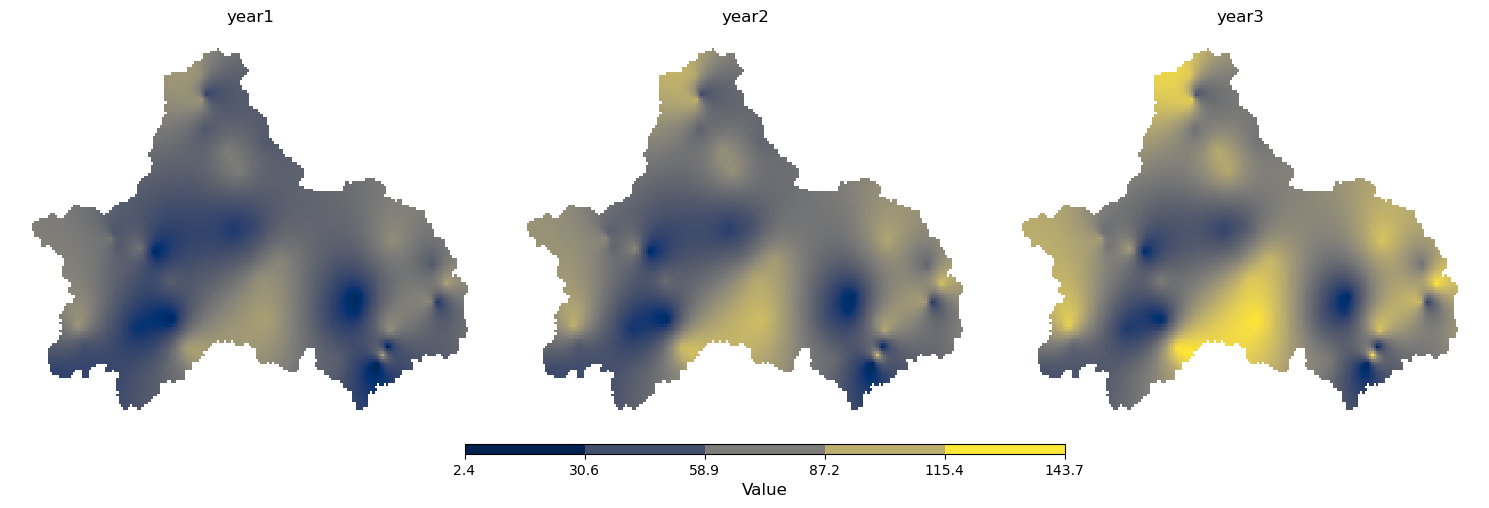

In [6]:
vmin = min(grid['year1'].min(), grid['year2'].min(), grid['year3'].min())
vmax = max(grid['year1'].max(), grid['year2'].max(), grid['year3'].max())
cmap = 'cividis'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['year1', 'year2', 'year3']):
    grid.plot(
        column=col,
        ax=ax[i],
        legend=False, 
        cmap=cmap,
        edgecolor='None',
        vmin=vmin,    
        vmax=vmax     
    )
    ax[i].set_title(col)
    ax[i].set_axis_off()


num_bins = 5
bins = np.linspace(vmin, vmax, num_bins + 1)
nbin = len(bins) - 1
cmap = plt.get_cmap(cmap, nbin)
norm = BoundaryNorm(bins, nbin)

im = ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])

cbar_width = 0.4
cbar_height = 0.02
cbar_bottom = 0.05  # 离底部的距离
cbar_left = (1 - cbar_width) / 2 +0.013
cbar_ax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Value', fontsize=12)
cbar.set_ticks(bins)
cbar.set_ticklabels([f'{b:.1f}' for b in bins])

plt.tight_layout()
plt.show()

## 三维